In [1]:
import pandas as pd
import glob
import os 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
%load_ext autoreload
%autoreload 2
from helpers_barplot_intersection import reader_assign_conf_pep, plot_text, plot_intersection_bars

Matplotlib created a temporary config/cache directory at /scratch/slurm-job.4141443/matplotlib-mvcfhv96 because the default path (/cluster/customapps/biomed/grlab/users/prelotla/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
# INPUTS 
read_from_disk = True # or reload
proteomicsdir = '/cluster/work/grlab/projects/projects2020_OHSU/proteomics_fixMerge_25012024'
#proteomicsdir = '/cluster/work/grlab/projects/projects2020_OHSU/proteomics'

pipelines = ['OHSU', 'ETH']

FDR_limit = 0.05
MS_FDR = '_crux' #choices: '_crema' '_crux' or ''
MS_strategy = 'joint' #Choices: 'pool' 'joint', 'single' 

#pool: pool all experiments per pipeline
#joint: pool all experiments for both pipeline
#single: per experiment per pipeline

if MS_FDR == '_crema':
    FDR_file = 'crema.peptides.txt'
    col_seq = 'sequence'
    col_qvalue = 'crema q-value'
elif MS_FDR == '_crux' or  MS_FDR == '':
    FDR_file = 'assign-confidence.target.txt'
    col_seq = 'unmodified sequence'
    col_qvalue = 'tdc q-value'
else:
    print(f'ERROR: wrong input for {FDR_file}')

    

sample_plot_dir = {}
run_type_plot_dir = {}    
all_samples = []

# BRCA
samples = ['TCGA-C8-A12P-01A-11R-A115-07',
                  'TCGA-AO-A0JM-01A-21R-A056-07',
                  'TCGA-BH-A18V-01A-11R-A12D-07',
                  'TCGA-A2-A0D2-01A-21R-A034-07',
                  'TCGA-A2-A0SX-01A-12R-A084-07']
all_samples.extend(samples)
basedir = '/cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/TCGA_Breast_1102'
filter_dir = os.path.join(basedir, 'filtering_samples', 'filters_19May_order_5ge_wAnnot_GPstar')

for sample in samples:
    sample_plot_dir[sample] = os.path.join(filter_dir, 'plots')
    run_type_plot_dir[sample] = 'BRCA'
    
# OV
samples = ['TCGA-25-1319-01A-01R-1565-13',
                  'TCGA-25-1313-01A-01R-1565-13',
                  'TCGA-61-2008-01A-02R-1568-13',
                  'TCGA-24-1431-01A-01R-1566-13',
                  'TCGA-24-2298-01A-01R-1569-13']
all_samples.extend(samples)
basedir = '/cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/TCGA_Ovarian_374'
filter_dir = os.path.join(basedir, 'filtering_samples', 'filters_19May_order_5ge_wAnnot_GPstar')

for sample in samples:
    sample_plot_dir[sample] = os.path.join(filter_dir, 'plots')
    run_type_plot_dir[sample] = 'OV'
    
    
    
# PLOTTING Parameters 
ticks_fontsize = 12
axislabels_fontsize = 12
legend_fontsize = 12
axes_fontsize = 15
save = True
sample = None

# Parse: results for all experiments

In [3]:
## Get peptides
if read_from_disk:
    samples_store_pep = {}
    samples_store_rates = {}
#     experiment_pipelines_peptides =  
#     experiments_pipelines_rates = defaultdict(dict)


    for sample in all_samples:

        sample_short = '-'.join(sample.split('-')[0:3])
        samples_store_pep[sample] = defaultdict(dict)
        samples_store_rates[sample] = defaultdict(dict)
        for pipeline in pipelines:
            path_single = os.path.join(proteomicsdir, pipeline, sample_short, 
                                       f'assign_conf_per_experiment{MS_FDR}')
            path_pool_pipeline = os.path.join(proteomicsdir, pipeline, sample_short, 
                                              f'assign_conf_pooled_FDR{MS_FDR}')
            path_pool_union = os.path.join(proteomicsdir, 
                                           f'assign_conf_joint_to_{pipeline}{MS_FDR}', sample_short)
            path_TEST_OHSU = os.path.join(proteomicsdir, 'OHSU', sample_short, 
                                       f'assign_conf_per_experiment{MS_FDR}')
            path_TEST_ETH = os.path.join(proteomicsdir, 'ETH', sample_short, 
                                       f'assign_conf_per_experiment{MS_FDR}')


            experiment_list = [ i.split('/')[-1] for i in glob.glob(path_single + '/*')] #check

            for experiment in experiment_list:
                if pipeline == 'OHSU':
                    original_name = experiment
                    cut_name = experiment[1:]
                else:
                    original_name = experiment
                    cut_name = experiment          

                if os.path.isfile(os.path.join(path_TEST_OHSU, 'J' + cut_name, FDR_file)) and \
                     os.path.isfile(os.path.join(path_TEST_ETH, cut_name, FDR_file)): #Commun experiments               

                    # search 1 experiment, 1 pipeline  
                    if MS_strategy == 'single':
                        df = os.path.join(path_single, original_name, FDR_file)
                    # search all experiments, 1 pipeline
                    if MS_strategy == 'pool':
                        df = os.path.join(path_pool_pipeline, f'tsearch-{original_name}.txt')
                    # search all experiments, 1 union of pipelines
                    if MS_strategy == 'joint':
                        df = os.path.join(path_pool_union, f'tsearch-{original_name}.txt')

                    val, val_rate, peptides, _ = reader_assign_conf_pep(df, FDR_limit, col_seq, col_qvalue)
                    samples_store_pep[sample][cut_name][pipeline] = peptides
                    samples_store_rates[sample][cut_name][pipeline] = val_rate

                    print('\n')


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics_fixMerge_25012024/assign_conf_joint_to_OHSU_crux/TCGA-C8-A12P/tsearch-J0A53XGA.txt
With Shape: 1490
With unique peptides: 30
Number of validated psm: (0, 18)
Number of validated unique peptides: 0
Validation Rate: 0.0 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics_fixMerge_25012024/assign_conf_joint_to_OHSU_crux/TCGA-C8-A12P/tsearch-J0A13AGA.txt
With Shape: 9477
With unique peptides: 253
Number of validated psm: (16, 18)
Number of validated unique peptides: 7
Validation Rate: 2.77 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics_fixMerge_25012024/assign_conf_joint_to_OHSU_crux/TCGA-C8-A12P/tsearch-J0A51XGA.txt
With Shape: 385
With unique peptides: 11
Number of validated psm: (0, 18)
Number of validated unique peptides: 0
Validation Rate: 0.0 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics_fixMerge_25012024/assign_conf_joint_to_OHSU_crux/T

Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics_fixMerge_25012024/assign_conf_joint_to_OHSU_crux/TCGA-C8-A12P/tsearch-J02112GA.txt
With Shape: 665
With unique peptides: 13
Number of validated psm: (9, 18)
Number of validated unique peptides: 1
Validation Rate: 7.69 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics_fixMerge_25012024/assign_conf_joint_to_OHSU_crux/TCGA-C8-A12P/tsearch-J0213AGA.txt
With Shape: 1740
With unique peptides: 49
Number of validated psm: (11, 18)
Number of validated unique peptides: 2
Validation Rate: 4.08 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics_fixMerge_25012024/assign_conf_joint_to_OHSU_crux/TCGA-C8-A12P/tsearch-J0AN3XGA.txt
With Shape: 41709
With unique peptides: 1128
Number of validated psm: (28, 18)
Number of validated unique peptides: 13
Validation Rate: 1.15 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics_fixMerge_25012024/assign_conf_joint_to_OHSU_

With Shape: 1864
With unique peptides: 38
Number of validated psm: (7, 18)
Number of validated unique peptides: 3
Validation Rate: 7.89 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics_fixMerge_25012024/assign_conf_joint_to_ETH_crux/TCGA-C8-A12P/tsearch-0A532GA.txt
With Shape: 383
With unique peptides: 9
Number of validated psm: (0, 18)
Number of validated unique peptides: 0
Validation Rate: 0.0 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics_fixMerge_25012024/assign_conf_joint_to_ETH_crux/TCGA-C8-A12P/tsearch-0A112GA.txt
With Shape: 381
With unique peptides: 9
Number of validated psm: (0, 18)
Number of validated unique peptides: 0
Validation Rate: 0.0 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics_fixMerge_25012024/assign_conf_joint_to_ETH_crux/TCGA-C8-A12P/tsearch-0A53XGA.txt
With Shape: 497
With unique peptides: 12
Number of validated psm: (0, 18)
Number of validated unique peptides: 0
Validation Rat

With Shape: 1917
With unique peptides: 47
Number of validated psm: (0, 18)
Number of validated unique peptides: 0
Validation Rate: 0.0 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics_fixMerge_25012024/assign_conf_joint_to_OHSU_crux/TCGA-AO-A0JM/tsearch-J0AN3XGA.txt
With Shape: 24910
With unique peptides: 557
Number of validated psm: (149, 18)
Number of validated unique peptides: 9
Validation Rate: 1.62 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics_fixMerge_25012024/assign_conf_joint_to_OHSU_crux/TCGA-AO-A0JM/tsearch-J02132GA.txt
With Shape: 368
With unique peptides: 9
Number of validated psm: (0, 18)
Number of validated unique peptides: 0
Validation Rate: 0.0 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics_fixMerge_25012024/assign_conf_joint_to_OHSU_crux/TCGA-AO-A0JM/tsearch-J0211XGA.txt
With Shape: 241
With unique peptides: 4
Number of validated psm: (0, 18)
Number of validated unique peptides: 0
Val

With Shape: 1
With unique peptides: 1
Number of validated psm: (0, 18)
Number of validated unique peptides: 0
Validation Rate: 0.0 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics_fixMerge_25012024/assign_conf_joint_to_OHSU_crux/TCGA-BH-A18V/tsearch-J0A53XGA.txt
With Shape: 845
With unique peptides: 32
Number of validated psm: (18, 18)
Number of validated unique peptides: 1
Validation Rate: 3.12 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics_fixMerge_25012024/assign_conf_joint_to_OHSU_crux/TCGA-BH-A18V/tsearch-J0A13AGA.txt
With Shape: 8099
With unique peptides: 267
Number of validated psm: (34, 18)
Number of validated unique peptides: 8
Validation Rate: 3.0 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics_fixMerge_25012024/assign_conf_joint_to_OHSU_crux/TCGA-BH-A18V/tsearch-J0A51XGA.txt
With Shape: 231
With unique peptides: 10
Number of validated psm: (0, 18)
Number of validated unique peptides: 0
Valida

With Shape: 23038
With unique peptides: 772
Number of validated psm: (71, 18)
Number of validated unique peptides: 19
Validation Rate: 2.46 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics_fixMerge_25012024/assign_conf_joint_to_OHSU_crux/TCGA-BH-A18V/tsearch-J02132GA.txt
With Shape: 862
With unique peptides: 28
Number of validated psm: (0, 18)
Number of validated unique peptides: 0
Validation Rate: 0.0 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics_fixMerge_25012024/assign_conf_joint_to_OHSU_crux/TCGA-BH-A18V/tsearch-J0211XGA.txt
With Shape: 635
With unique peptides: 17
Number of validated psm: (0, 18)
Number of validated unique peptides: 0
Validation Rate: 0.0 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics_fixMerge_25012024/assign_conf_joint_to_OHSU_crux/TCGA-BH-A18V/tsearch-J0AN1XGA.txt
With Shape: 12473
With unique peptides: 425
Number of validated psm: (37, 18)
Number of validated unique peptides: 

With Shape: 1267
With unique peptides: 36
Number of validated psm: (2, 18)
Number of validated unique peptides: 1
Validation Rate: 2.78 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics_fixMerge_25012024/assign_conf_joint_to_OHSU_crux/TCGA-A2-A0D2/tsearch-J0A13AGA.txt
With Shape: 8550
With unique peptides: 231
Number of validated psm: (18, 18)
Number of validated unique peptides: 9
Validation Rate: 3.9 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics_fixMerge_25012024/assign_conf_joint_to_OHSU_crux/TCGA-A2-A0D2/tsearch-J0213XGA.txt
With Shape: 1397
With unique peptides: 38
Number of validated psm: (0, 18)
Number of validated unique peptides: 0
Validation Rate: 0.0 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics_fixMerge_25012024/assign_conf_joint_to_OHSU_crux/TCGA-A2-A0D2/tsearch-J0AN01GA.txt
With Shape: 14639
With unique peptides: 419
Number of validated psm: (11, 18)
Number of validated unique peptides: 

With Shape: 849
With unique peptides: 24
Number of validated psm: (0, 18)
Number of validated unique peptides: 0
Validation Rate: 0.0 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics_fixMerge_25012024/assign_conf_joint_to_ETH_crux/TCGA-A2-A0D2/tsearch-0A11AGA.txt
With Shape: 109
With unique peptides: 2
Number of validated psm: (0, 18)
Number of validated unique peptides: 0
Validation Rate: 0.0 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics_fixMerge_25012024/assign_conf_joint_to_ETH_crux/TCGA-A2-A0D2/tsearch-0AN01GA.txt
With Shape: 152
With unique peptides: 5
Number of validated psm: (0, 18)
Number of validated unique peptides: 0
Validation Rate: 0.0 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics_fixMerge_25012024/assign_conf_joint_to_ETH_crux/TCGA-A2-A0D2/tsearch-0AN1XGA.txt
With Shape: 152
With unique peptides: 5
Number of validated psm: (0, 18)
Number of validated unique peptides: 0
Validation Rate: 

With Shape: 152
With unique peptides: 5
Number of validated psm: (0, 18)
Number of validated unique peptides: 0
Validation Rate: 0.0 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics_fixMerge_25012024/assign_conf_joint_to_OHSU_crux/TCGA-A2-A0SX/tsearch-J0AN12GA.txt
With Shape: 10645
With unique peptides: 391
Number of validated psm: (20, 18)
Number of validated unique peptides: 5
Validation Rate: 1.28 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics_fixMerge_25012024/assign_conf_joint_to_OHSU_crux/TCGA-A2-A0SX/tsearch-J0A11AGA.txt
With Shape: 1490
With unique peptides: 52
Number of validated psm: (7, 18)
Number of validated unique peptides: 2
Validation Rate: 3.85 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics_fixMerge_25012024/assign_conf_joint_to_OHSU_crux/TCGA-A2-A0SX/tsearch-J0A101GA.txt
With Shape: 1478
With unique peptides: 50
Number of validated psm: (7, 18)
Number of validated unique peptides: 2
V

With Shape: 108
With unique peptides: 7
Number of validated psm: (0, 18)
Number of validated unique peptides: 0
Validation Rate: 0.0 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics_fixMerge_25012024/assign_conf_joint_to_ETH_crux/TCGA-A2-A0SX/tsearch-0A11AGA.txt
With Shape: 31
With unique peptides: 1
Number of validated psm: (0, 18)
Number of validated unique peptides: 0
Validation Rate: 0.0 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics_fixMerge_25012024/assign_conf_joint_to_ETH_crux/TCGA-A2-A0SX/tsearch-0AN01GA.txt
With Shape: 287
With unique peptides: 13
Number of validated psm: (0, 18)
Number of validated unique peptides: 0
Validation Rate: 0.0 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics_fixMerge_25012024/assign_conf_joint_to_ETH_crux/TCGA-A2-A0SX/tsearch-0AN1XGA.txt
With Shape: 303
With unique peptides: 14
Number of validated psm: (0, 18)
Number of validated unique peptides: 0
Validation Rate: 

With Shape: 26102
With unique peptides: 7896
Number of validated psm: (628, 18)
Number of validated unique peptides: 244
Validation Rate: 3.09 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics_fixMerge_25012024/assign_conf_joint_to_OHSU_crux/TCGA-25-1319/tsearch-J0AN01GA.txt
With Shape: 101008
With unique peptides: 31449
Number of validated psm: (1284, 18)
Number of validated unique peptides: 599
Validation Rate: 1.9 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics_fixMerge_25012024/assign_conf_joint_to_OHSU_crux/TCGA-25-1319/tsearch-J0A532GA.txt
With Shape: 34103
With unique peptides: 10457
Number of validated psm: (746, 18)
Number of validated unique peptides: 305
Validation Rate: 2.92 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics_fixMerge_25012024/assign_conf_joint_to_OHSU_crux/TCGA-25-1319/tsearch-J0A11XGA.txt
With Shape: 58774
With unique peptides: 18384
Number of validated psm: (880, 18)
Number of 

Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics_fixMerge_25012024/assign_conf_joint_to_OHSU_crux/TCGA-25-1319/tsearch-J0AN3XGA.txt
With Shape: 117974
With unique peptides: 36345
Number of validated psm: (1628, 18)
Number of validated unique peptides: 730
Validation Rate: 2.01 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics_fixMerge_25012024/assign_conf_joint_to_OHSU_crux/TCGA-25-1319/tsearch-J02132GA.txt
With Shape: 21497
With unique peptides: 6580
Number of validated psm: (518, 18)
Number of validated unique peptides: 194
Validation Rate: 2.95 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics_fixMerge_25012024/assign_conf_joint_to_OHSU_crux/TCGA-25-1319/tsearch-J0211XGA.txt
With Shape: 18062
With unique peptides: 5631
Number of validated psm: (370, 18)
Number of validated unique peptides: 162
Validation Rate: 2.88 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics_fixMerge_25012024/assign_

With Shape: 63873
With unique peptides: 19508
Number of validated psm: (1034, 18)
Number of validated unique peptides: 370
Validation Rate: 1.9 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics_fixMerge_25012024/assign_conf_joint_to_ETH_crux/TCGA-25-1319/tsearch-0AN3AGA.txt
With Shape: 108386
With unique peptides: 32887
Number of validated psm: (1691, 18)
Number of validated unique peptides: 620
Validation Rate: 1.89 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics_fixMerge_25012024/assign_conf_joint_to_ETH_crux/TCGA-25-1319/tsearch-0A51XGA.txt
With Shape: 58020
With unique peptides: 17767
Number of validated psm: (983, 18)
Number of validated unique peptides: 341
Validation Rate: 1.92 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics_fixMerge_25012024/assign_conf_joint_to_ETH_crux/TCGA-25-1319/tsearch-02501GA.txt
With Shape: 38336
With unique peptides: 11728
Number of validated psm: (518, 18)
Number of vali

With Shape: 66770
With unique peptides: 13089
Number of validated psm: (805, 18)
Number of validated unique peptides: 319
Validation Rate: 2.44 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics_fixMerge_25012024/assign_conf_joint_to_OHSU_crux/TCGA-25-1313/tsearch-J0A512GA.txt
With Shape: 20001
With unique peptides: 3806
Number of validated psm: (386, 18)
Number of validated unique peptides: 129
Validation Rate: 3.39 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics_fixMerge_25012024/assign_conf_joint_to_OHSU_crux/TCGA-25-1313/tsearch-J0A112GA.txt
With Shape: 37634
With unique peptides: 7268
Number of validated psm: (576, 18)
Number of validated unique peptides: 216
Validation Rate: 2.97 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics_fixMerge_25012024/assign_conf_joint_to_OHSU_crux/TCGA-25-1313/tsearch-J0AN1AGA.txt
With Shape: 61390
With unique peptides: 12070
Number of validated psm: (734, 18)
Number of va

With Shape: 34559
With unique peptides: 6662
Number of validated psm: (410, 18)
Number of validated unique peptides: 111
Validation Rate: 1.67 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics_fixMerge_25012024/assign_conf_joint_to_ETH_crux/TCGA-25-1313/tsearch-0AN32GA.txt
With Shape: 40583
With unique peptides: 7904
Number of validated psm: (442, 18)
Number of validated unique peptides: 125
Validation Rate: 1.58 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics_fixMerge_25012024/assign_conf_joint_to_ETH_crux/TCGA-25-1313/tsearch-02101GA.txt
With Shape: 25311
With unique peptides: 4873
Number of validated psm: (326, 18)
Number of validated unique peptides: 89
Validation Rate: 1.83 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics_fixMerge_25012024/assign_conf_joint_to_ETH_crux/TCGA-25-1313/tsearch-0A11XGA.txt
With Shape: 32023
With unique peptides: 6194
Number of validated psm: (392, 18)
Number of validated u

With Shape: 98967
With unique peptides: 28755
Number of validated psm: (3120, 18)
Number of validated unique peptides: 897
Validation Rate: 3.12 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics_fixMerge_25012024/assign_conf_joint_to_OHSU_crux/TCGA-61-2008/tsearch-J0A532GA.txt
With Shape: 36791
With unique peptides: 10020
Number of validated psm: (2167, 18)
Number of validated unique peptides: 438
Validation Rate: 4.37 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics_fixMerge_25012024/assign_conf_joint_to_OHSU_crux/TCGA-61-2008/tsearch-J0A11XGA.txt
With Shape: 59787
With unique peptides: 17011
Number of validated psm: (2286, 18)
Number of validated unique peptides: 629
Validation Rate: 3.7 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics_fixMerge_25012024/assign_conf_joint_to_OHSU_crux/TCGA-61-2008/tsearch-J0253XGA.txt
With Shape: 14606
With unique peptides: 3629
Number of validated psm: (1048, 18)
Number o

With Shape: 19587
With unique peptides: 5441
Number of validated psm: (969, 18)
Number of validated unique peptides: 238
Validation Rate: 4.37 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics_fixMerge_25012024/assign_conf_joint_to_OHSU_crux/TCGA-61-2008/tsearch-J0AN1XGA.txt
With Shape: 100444
With unique peptides: 29182
Number of validated psm: (3204, 18)
Number of validated unique peptides: 918
Validation Rate: 3.15 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics_fixMerge_25012024/assign_conf_joint_to_ETH_crux/TCGA-61-2008/tsearch-0211AGA.txt
With Shape: 64915
With unique peptides: 18589
Number of validated psm: (2276, 18)
Number of validated unique peptides: 555
Validation Rate: 2.99 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics_fixMerge_25012024/assign_conf_joint_to_ETH_crux/TCGA-61-2008/tsearch-0211XGA.txt
With Shape: 64915
With unique peptides: 18589
Number of validated psm: (2276, 18)
Number of v

With Shape: 44804
With unique peptides: 12833
Number of validated psm: (1405, 18)
Number of validated unique peptides: 366
Validation Rate: 2.85 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics_fixMerge_25012024/assign_conf_joint_to_ETH_crux/TCGA-61-2008/tsearch-0AN3XGA.txt
With Shape: 126599
With unique peptides: 36094
Number of validated psm: (4189, 18)
Number of validated unique peptides: 1107
Validation Rate: 3.07 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics_fixMerge_25012024/assign_conf_joint_to_ETH_crux/TCGA-61-2008/tsearch-0A532GA.txt
With Shape: 93736
With unique peptides: 26771
Number of validated psm: (3289, 18)
Number of validated unique peptides: 800
Validation Rate: 2.99 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics_fixMerge_25012024/assign_conf_joint_to_ETH_crux/TCGA-61-2008/tsearch-0A112GA.txt
With Shape: 72573
With unique peptides: 20758
Number of validated psm: (2517, 18)
Number of 

With Shape: 44269
With unique peptides: 8417
Number of validated psm: (895, 18)
Number of validated unique peptides: 283
Validation Rate: 3.36 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics_fixMerge_25012024/assign_conf_joint_to_OHSU_crux/TCGA-24-1431/tsearch-J0AN1AGA.txt
With Shape: 70284
With unique peptides: 13460
Number of validated psm: (1055, 18)
Number of validated unique peptides: 380
Validation Rate: 2.82 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics_fixMerge_25012024/assign_conf_joint_to_OHSU_crux/TCGA-24-1431/tsearch-J02532GA.txt
With Shape: 9252
With unique peptides: 1702
Number of validated psm: (239, 18)
Number of validated unique peptides: 73
Validation Rate: 4.29 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics_fixMerge_25012024/assign_conf_joint_to_OHSU_crux/TCGA-24-1431/tsearch-J0A13XGA.txt
With Shape: 56707
With unique peptides: 10776
Number of validated psm: (1166, 18)
Number of va

With Shape: 46365
With unique peptides: 8616
Number of validated psm: (873, 18)
Number of validated unique peptides: 228
Validation Rate: 2.65 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics_fixMerge_25012024/assign_conf_joint_to_ETH_crux/TCGA-24-1431/tsearch-02101GA.txt
With Shape: 29960
With unique peptides: 5533
Number of validated psm: (514, 18)
Number of validated unique peptides: 156
Validation Rate: 2.82 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics_fixMerge_25012024/assign_conf_joint_to_ETH_crux/TCGA-24-1431/tsearch-0A11XGA.txt
With Shape: 36190
With unique peptides: 6695
Number of validated psm: (664, 18)
Number of validated unique peptides: 188
Validation Rate: 2.81 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics_fixMerge_25012024/assign_conf_joint_to_ETH_crux/TCGA-24-1431/tsearch-02132GA.txt
With Shape: 40629
With unique peptides: 7540
Number of validated psm: (728, 18)
Number of validated 

With Shape: 44790
With unique peptides: 15732
Number of validated psm: (1443, 18)
Number of validated unique peptides: 556
Validation Rate: 3.53 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics_fixMerge_25012024/assign_conf_joint_to_OHSU_crux/TCGA-24-2298/tsearch-J0253XGA.txt
With Shape: 9756
With unique peptides: 3278
Number of validated psm: (517, 18)
Number of validated unique peptides: 153
Validation Rate: 4.67 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics_fixMerge_25012024/assign_conf_joint_to_OHSU_crux/TCGA-24-2298/tsearch-J0251XGA.txt
With Shape: 5998
With unique peptides: 2054
Number of validated psm: (260, 18)
Number of validated unique peptides: 86
Validation Rate: 4.19 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics_fixMerge_25012024/assign_conf_joint_to_OHSU_crux/TCGA-24-2298/tsearch-J0AN3AGA.txt
With Shape: 89610
With unique peptides: 31757
Number of validated psm: (2450, 18)
Number of val

With Shape: 75318
With unique peptides: 26816
Number of validated psm: (1975, 18)
Number of validated unique peptides: 810
Validation Rate: 3.02 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics_fixMerge_25012024/assign_conf_joint_to_ETH_crux/TCGA-24-2298/tsearch-0211AGA.txt
With Shape: 50562
With unique peptides: 17809
Number of validated psm: (1408, 18)
Number of validated unique peptides: 505
Validation Rate: 2.84 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics_fixMerge_25012024/assign_conf_joint_to_ETH_crux/TCGA-24-2298/tsearch-0211XGA.txt
With Shape: 50562
With unique peptides: 17809
Number of validated psm: (1408, 18)
Number of validated unique peptides: 505
Validation Rate: 2.84 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics_fixMerge_25012024/assign_conf_joint_to_ETH_crux/TCGA-24-2298/tsearch-02532GA.txt
With Shape: 49530
With unique peptides: 17497
Number of validated psm: (1326, 18)
Number of va

With Shape: 94291
With unique peptides: 33453
Number of validated psm: (2395, 18)
Number of validated unique peptides: 923
Validation Rate: 2.76 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics_fixMerge_25012024/assign_conf_joint_to_ETH_crux/TCGA-24-2298/tsearch-0A532GA.txt
With Shape: 68023
With unique peptides: 24136
Number of validated psm: (1757, 18)
Number of validated unique peptides: 658
Validation Rate: 2.73 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics_fixMerge_25012024/assign_conf_joint_to_ETH_crux/TCGA-24-2298/tsearch-0A112GA.txt
With Shape: 55754
With unique peptides: 19670
Number of validated psm: (1523, 18)
Number of validated unique peptides: 558
Validation Rate: 2.84 percent


Reading /cluster/work/grlab/projects/projects2020_OHSU/proteomics_fixMerge_25012024/assign_conf_joint_to_ETH_crux/TCGA-24-2298/tsearch-0A53XGA.txt
With Shape: 88500
With unique peptides: 31424
Number of validated psm: (2239, 18)
Number of va

In [4]:
## Compare peptides
if read_from_disk:
    compare = {'sample' : [], 
              'filter_' : [], 
              'pep_size_ohsu' : [], 
              'pep_size_eth' : [], 
              'pep_size_intersection' : [], 
              'pep_size_ohsu\eth' : [], 
              'pep_size_eth\ohsu' : []}

    for sample, experiments_ in samples_store_pep.items():
        for experiment, pipelines_ in experiments_.items():
            if ('OHSU' in pipelines_.keys()) and ('ETH' in pipelines_.keys()):
                compare['sample'].append(sample)
                compare['filter_'].append(experiment)
                compare['pep_size_ohsu'].append(len(pipelines_['OHSU']))
                compare['pep_size_eth'].append(len(pipelines_['ETH']))
                compare['pep_size_ohsu\eth'].append(len(pipelines_['OHSU'].difference(pipelines_['ETH'])))
                compare['pep_size_eth\ohsu'].append(len(pipelines_['ETH'].difference(pipelines_['OHSU'])))
                compare['pep_size_intersection'].append(len(pipelines_['ETH'].intersection(pipelines_['OHSU'])))

# Plot: Results per experiment

In [5]:
# Choose plotting sample
sample = 'TCGA-25-1319-01A-01R-1565-13'
#sample =  'TCGA-AO-A0JM-01A-21R-A056-07'

In [6]:
if read_from_disk:
    df = pd.DataFrame(compare)
    display(df.head())
    print(df.shape)
else:
    df = None

,sample,filter_,pep_size_ohsu,pep_size_eth,pep_size_intersection,pep_size_ohsu\eth,pep_size_eth\ohsu
0,TCGA-C8-A12P-01A-11R-A115-07,0A53XGA,0,0,0,0,0
1,TCGA-C8-A12P-01A-11R-A115-07,0A13AGA,7,1,0,7,1
2,TCGA-C8-A12P-01A-11R-A115-07,0A51XGA,0,0,0,0,0
3,TCGA-C8-A12P-01A-11R-A115-07,0213XGA,1,1,0,1,1
4,TCGA-C8-A12P-01A-11R-A115-07,0AN01GA,8,2,2,6,0


(330, 7)


In [7]:
def run_sample_plotting(sample_plot_dir, sample, df, MS_FDR, MS_strategy, save):
    order_file = os.path.join(sample_plot_dir[sample], f'{sample}_Barplot_sorting.tsv.gz')
    order_file = pd.read_csv(order_file, sep = '\t')
    display(order_file.head())
    print(order_file.shape)
    df_plot = order_file.merge(df, on = ['sample', 'filter_'], how = 'inner')
    df_plot = df_plot.fillna(0)
    print(df_plot.shape)
    df_plot = df_plot.sort_values('index')
    display(df_plot.head())
    # Plotting
    run_type = run_type_plot_dir[sample]

    back_ticks = df_plot['filter_background'] 
    front_ticks = df_plot['filter_foreground']

    serie_index = df_plot['index']
    serie_intersection = df_plot['pep_size_intersection']
    serie_eth = df_plot['pep_size_eth']
    print(serie_eth)
    serie_ohsu = df_plot['pep_size_ohsu']
    y_label = 'Number of MS-detected tryptic junction-peptides'

    name_plot = f'Barplot_ovelap_protein{MS_FDR}_{MS_strategy}'
    base_plot = sample
    plot_dir = sample_plot_dir[sample]

    plot_intersection_bars(back_ticks, front_ticks, ticks_fontsize, axislabels_fontsize, 
                              legend_fontsize, axes_fontsize, run_type, 
                               serie_index, serie_intersection, serie_eth, serie_ohsu,
                               y_label, save, plot_dir, base_plot, name_plot)
    return df_plot

/cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/TCGA_Ovarian_374/filtering_samples/filters_19May_order_5ge_wAnnot_GPstar/plots/data_crux_joint.tsv.gz


,Unnamed: 0,sample,filter_,size_ohsu,size_eth,size_intersection,size_ohsu\eth,size_eth\ohsu,filter_foreground_target,filter_foreground_reads,filter_foreground_samples,filter_background_reads,filter_background_samples,cohort,motif,index,filter_background,filter_foreground
0,7,TCGA-25-1319-01A-01R-1565-13,02501GA,23972,20052,8874,15098,11178,0,2,5,0,1,G,A,0,"(0, 1)","(0, 2, 5)"
1,30,TCGA-25-1319-01A-01R-1565-13,02512GA,24766,20638,9166,15600,11472,0,2,5,1,2,G,A,1,"(1, 2)","(0, 2, 5)"
2,14,TCGA-25-1319-01A-01R-1565-13,0251AGA,24913,20683,9193,15720,11490,0,2,5,1,A,G,A,2,"(1, A)","(0, 2, 5)"
3,8,TCGA-25-1319-01A-01R-1565-13,0251XGA,24913,20683,9193,15720,11490,0,2,5,1,X,G,A,3,"(1, X)","(0, 2, 5)"
4,15,TCGA-25-1319-01A-01R-1565-13,02532GA,29573,24940,11086,18487,13854,0,2,5,3,2,G,A,4,"(3, 2)","(0, 2, 5)"


(35, 18)
(35, 23)


,Unnamed: 0,sample,filter_,size_ohsu,size_eth,size_intersection,size_ohsu\eth,size_eth\ohsu,filter_foreground_target,filter_foreground_reads,...,cohort,motif,index,filter_background,filter_foreground,pep_size_ohsu,pep_size_eth,pep_size_intersection,pep_size_ohsu\eth,pep_size_eth\ohsu
0,7,TCGA-25-1319-01A-01R-1565-13,02501GA,23972,20052,8874,15098,11178,0,2,...,G,A,0,"(0, 1)","(0, 2, 5)",89,217,35,54,182
1,30,TCGA-25-1319-01A-01R-1565-13,02512GA,24766,20638,9166,15600,11472,0,2,...,G,A,1,"(1, 2)","(0, 2, 5)",93,232,38,55,194
2,14,TCGA-25-1319-01A-01R-1565-13,0251AGA,24913,20683,9193,15720,11490,0,2,...,G,A,2,"(1, A)","(0, 2, 5)",93,232,38,55,194
3,8,TCGA-25-1319-01A-01R-1565-13,0251XGA,24913,20683,9193,15720,11490,0,2,...,G,A,3,"(1, X)","(0, 2, 5)",93,232,38,55,194
4,15,TCGA-25-1319-01A-01R-1565-13,02532GA,29573,24940,11086,18487,13854,0,2,...,G,A,4,"(3, 2)","(0, 2, 5)",109,287,52,57,235


0     217
1     232
2     232
3     232
4     287
5     393
6     432
7     309
8     324
9     324
10    324
11    393
12    326
13    341
14    341
15    341
16    520
17    558
18    413
19    353
20    368
21    368
22    368
23    355
24    370
25    370
26    370
27    549
28    588
29    440
30    443
31    579
32    618
33    583
34    620
Name: pep_size_eth, dtype: int64
saving path is to /cluster/work/grlab/projects/projects2020_OHSU/peptides_generation/CANCER_eth/commit_c4dd02c_conf2_Frame_cap0_runs/TCGA_Ovarian_374/filtering_samples/filters_19May_order_5ge_wAnnot_GPstar/plots/TCGA-25-1319-01A-01R-1565-13_Barplot_ovelap_protein_crux_joint.pdf
Saving!


/cluster/home/prelotla/github/projects2020_ohsu/eth/plotting/OHSU_collab_Rerun_allRF_proteomics/helpers_barplot_intersection.py:98: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  plt.grid(b=False, axis = 'both', which='minor', color=colorgrid, linestyle='--', alpha=alpha_grid)


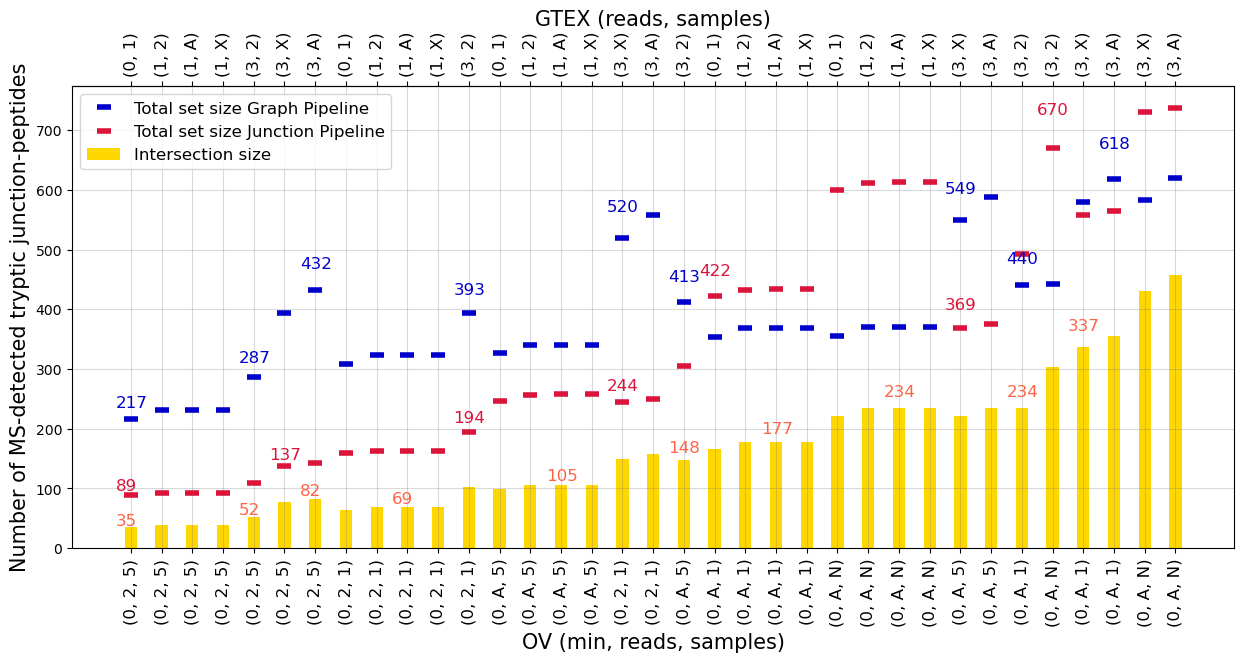

In [8]:
# TMP CODE single sample
save = True
path_data = os.path.join(sample_plot_dir[sample], f'data{MS_FDR}_{MS_strategy}.tsv.gz')
print(path_data)
if df is not None:
    df.to_csv(path_data, sep = '\t', index = None)
else:
    df = pd.read_csv(path_data, sep = '\t')
df_plot = run_sample_plotting(sample_plot_dir, sample, df, MS_FDR, MS_strategy, save)

In [9]:
# for sample in all_samples:
#     path_data = os.path.join(sample_plot_dir[sample], f'data{MS_FDR}_{MS_strategy}.tsv.gz')
#     print(path_data)
#     if df is not None:
#         df.to_csv(path_data, sep = '\t', index = None)
#     else:
#         df = pd.read_csv(path_data, sep = '\t')
#     run_sample_plotting(sample_plot_dir, sample, df, MS_FDR, MS_strategy, save)